In [1]:
pwd

'/home/roman/CODE/tachikoma-analysis/DATA2'

In [2]:
!du -sh /home/roman/mne_data


60G	/home/roman/mne_data


In [3]:
import sys, os, torch
from tqdm import tqdm
import numpy as np
import moabb 
import pandas as pd
from moabb.datasets import (Zhou2016,
                            PhysionetMI,
                            AlexMI,
                            MunichMI,
                            BNCI2014001,
                            BNCI2014002,
                            BNCI2014004,
                            BNCI2015001,
                            BNCI2015004,
                            Cho2017,
                            Weibo2014, 
                            Shin2017A,
                            Ofner2017,
                            Schirrmeister2017)
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io
from termcolor import cprint


from sklearn.pipeline import make_pipeline

import mne
from mne.decoding import CSP

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from moabb.paradigms import LeftRightImagery, MotorImagery

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [4]:
%%time

ds = Schirrmeister2017()

print(f'N_subj: {len(ds.subject_list)}')


ChOI = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']
eventsOI  = ['right_hand', 'left_hand', 'rest', 'feet']

subject_list = ds.subject_list

A = []
MM, XX = [], []

for sid in tqdm(subject_list):
    with HiddenPrints():
        ds.download(subject_list=subject_list)

    events = list(ds.event_id.keys())
    cprint(events, 'red')
    

    n_classes = len(events)
    paradigm = MotorImagery(n_classes=n_classes, 
                            events=events, 
                            tmin=0,
                            tmax=None, #  – End time (in second) of the epoch, relative to the begining of the dataset specific task interval. tmax = 5 would mean the epoch will end 5 second after the begining of the task as defined in the dataset. If None, use the dataset value.
                            baseline=(0, 0.5),
                            channels=None,
                            resample=60, 
                            fmin=0.05,
                            fmax=30) # <<<<<<<<<<

    # get data for all the subjects, sessions and runs in the dataset

    dat = ds.get_data([sid])
    for k in dat[sid].keys():
        for kk in dat[sid][k]:
            ch_names = dat[sid][k][kk].ch_names
            chIDs = np.array([i for i, n in enumerate(ch_names) if n in ChOI])
            A.append(chIDs)
    print(ch_names)

    X__, labels_, meta_ = paradigm.get_data(dataset=ds, subjects=[sid])
    meta_['label'] = labels_
    
    trialsOI = np.where(meta_.label.isin(eventsOI))[0]
    meta = meta_.iloc[trialsOI]#.reset_index(drop=True)
    X_ = X__[trialsOI, :, :]
    X = X_[:, chIDs, :]
    XX.append(X)
    MM.append(meta.to_dict(orient='records'))

    cprint(f'{X.shape}, {np.unique(labels_)}', color='blue')
    
MM_ = []
for i in MM:
    for j in i:
        MM_.append(j)
meta = pd.DataFrame(MM_)
samples = np.concatenate(XX, axis=0)



N_subj: 14


  0%|                                                                                                                                  | 0/14 [00:00<?, ?it/s]

['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/1.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
Channel 'EEG FC6' recognized as type EEG (renamed to 'FC6

Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1225999  =      0.000 ...  2451.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/1.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type E

Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 616999  =      0.000 ...  1233.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2', 'AF7', 'AF3', 'AF4', 'A

Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' recognized as type EEG (renamed to 'CCP1h').
Channel 'EEG CCP2h' rec

Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (r

  7%|████████▋                                                                                                                 | 1/14 [01:23<18:06, 83.55s/it]

(480, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/2.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
C

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3131499  =      0.000 ...  6262.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/2.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as 

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 614499  =      0.000 ...  1228.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 14%|█████████████████▎                                                                                                       | 2/14 [03:21<20:42, 103.55s/it]

(973, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/3.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
C

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3347499  =      0.000 ...  6694.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/3.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as 

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 609499  =      0.000 ...  1218.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 21%|█████████████████████████▉                                                                                               | 3/14 [05:17<20:05, 109.57s/it]

(1040, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/4.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').


Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3451499  =      0.000 ...  6902.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/4.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as 

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617499  =      0.000 ...  1234.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

Channel 'EEG CCP3h' recognized as type EEG (renamed to 'CCP3h').
Channel 'EEG CCP4h' recognized as type EEG (renamed to 'CCP4h').
Channel 'EEG CCP6h' recognized as type EEG (renamed to 'CCP6h').
Channel 'EEG CPP5h' recognized as type EEG (renamed to 'CPP5h').
Channel 'EEG CPP3h' recognized as type EEG (renamed to 'CPP3h').
Channel 'EEG CPP4h' recognized as type EEG (renamed to 'CPP4h').
Channel 'EEG CPP6h' recognized as type EEG (renamed to 'CPP6h').
Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (ren

Channel 'EEG FCC5h' recognized as type EEG (renamed to 'FCC5h').
Channel 'EEG FCC3h' recognized as type EEG (renamed to 'FCC3h').
Channel 'EEG FCC4h' recognized as type EEG (renamed to 'FCC4h').
Channel 'EEG FCC6h' recognized as type EEG (renamed to 'FCC6h').
Channel 'EEG CCP5h' recognized as type EEG (renamed to 'CCP5h').
Channel 'EEG CCP3h' recognized as type EEG (renamed to 'CCP3h').
Channel 'EEG CCP4h' recognized as type EEG (renamed to 'CCP4h').
Channel 'EEG CCP6h' recognized as type EEG (renamed to 'CCP6h').
Channel 'EEG CPP5h' recognized as type EEG (renamed to 'CPP5h').
Channel 'EEG CPP3h' recognized as type EEG (renamed to 'CPP3h').
Channel 'EEG CPP4h' recognized as type EEG (renamed to 'CPP4h').
Channel 'EEG CPP6h' recognized as type EEG (renamed to 'CPP6h').
Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type

Channel 'EEG PO6' recognized as type EEG (renamed to 'PO6').
Channel 'EEG FT7' recognized as type EEG (renamed to 'FT7').
Channel 'EEG FT8' recognized as type EEG (renamed to 'FT8').
Channel 'EEG TP7' recognized as type EEG (renamed to 'TP7').
Channel 'EEG TP8' recognized as type EEG (renamed to 'TP8').
Channel 'EEG PO7' recognized as type EEG (renamed to 'PO7').
Channel 'EEG PO8' recognized as type EEG (renamed to 'PO8').
Channel 'EEG FT9' recognized as type EEG (renamed to 'FT9').
Channel 'EEG FT10' recognized as type EEG (renamed to 'FT10').
Channel 'EEG TPP9h' recognized as type EEG (renamed to 'TPP9h').
Channel 'EEG TPP10h' recognized as type EEG (renamed to 'TPP10h').
Channel 'EEG PO9' recognized as type EEG (renamed to 'PO9').
Channel 'EEG PO10' recognized as type EEG (renamed to 'PO10').
Channel 'EEG P9' recognized as type EEG (renamed to 'P9').
Channel 'EEG P10' recognized as type EEG (renamed to 'P10').
Channel 'EEG AFF1' recognized as type EEG (renamed to 'AFF1').
Channel 'E

Channel 'EEG P1' recognized as type EEG (renamed to 'P1').
Channel 'EEG P2' recognized as type EEG (renamed to 'P2').
Channel 'EEG P6' recognized as type EEG (renamed to 'P6').
Channel 'EEG PO5' recognized as type EEG (renamed to 'PO5').
Channel 'EEG PO3' recognized as type EEG (renamed to 'PO3').
Channel 'EEG PO4' recognized as type EEG (renamed to 'PO4').
Channel 'EEG PO6' recognized as type EEG (renamed to 'PO6').
Channel 'EEG FT7' recognized as type EEG (renamed to 'FT7').
Channel 'EEG FT8' recognized as type EEG (renamed to 'FT8').
Channel 'EEG TP7' recognized as type EEG (renamed to 'TP7').
Channel 'EEG TP8' recognized as type EEG (renamed to 'TP8').
Channel 'EEG PO7' recognized as type EEG (renamed to 'PO7').
Channel 'EEG PO8' recognized as type EEG (renamed to 'PO8').
Channel 'EEG FT9' recognized as type EEG (renamed to 'FT9').
Channel 'EEG FT10' recognized as type EEG (renamed to 'FT10').
Channel 'EEG TPP9h' recognized as type EEG (renamed to 'TPP9h').
Channel 'EEG TPP10h' rec

 36%|███████████████████████████████████████████▏                                                                             | 5/14 [08:59<16:26, 109.58s/it]

(880, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/6.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
C

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3387499  =      0.000 ...  6774.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/6.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as 

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 615999  =      0.000 ...  1231.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 43%|███████████████████████████████████████████████████▊                                                                     | 6/14 [10:57<14:57, 112.20s/it]

(1040, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']


 50%|████████████████████████████████████████████████████████████▌                                                            | 7/14 [12:53<13:14, 113.52s/it]

(1040, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/8.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').


Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2511999  =      0.000 ...  5023.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/8.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as 

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 616499  =      0.000 ...  1232.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 57%|█████████████████████████████████████████████████████████████████████▏                                                   | 8/14 [14:31<10:52, 108.79s/it]

(814, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/9.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').
C

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3383999  =      0.000 ...  6767.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/9.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as 

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 614999  =      0.000 ...  1229.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 64%|█████████████████████████████████████████████████████████████████████████████▊                                           | 9/14 [16:29<09:17, 111.60s/it]

(1040, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/10.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3386499  =      0.000 ...  6772.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/10.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 614999  =      0.000 ...  1229.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 71%|█████████████████████████████████████████████████████████████████████████████████████▋                                  | 10/14 [18:27<07:34, 113.57s/it]

(1040, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/11.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3386999  =      0.000 ...  6773.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/11.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 610999  =      0.000 ...  1221.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 11/14 [20:24<05:44, 114.69s/it]

(1040, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/12.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3385999  =      0.000 ...  6771.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/12.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as

Channel 'EEG TPP8h' recognized as type EEG (renamed to 'TPP8h').
Channel 'EEG PPO9h' recognized as type EEG (renamed to 'PPO9h').
Channel 'EEG PPO5h' recognized as type EEG (renamed to 'PPO5h').
Channel 'EEG PPO6h' recognized as type EEG (renamed to 'PPO6h').
Channel 'EEG PPO10h' recognized as type EEG (renamed to 'PPO10h').
Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 617999  =      0.000 ...  1235.998 secs...
['Fp1', 'Fp2', 'Fpz', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', '

Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (renamed to 'FCC1h').
Channel 'EEG FCC2h' recognized as type EEG (renamed to 'FCC2h').
Channel 'EEG FTT8h' recognized as type EEG (renamed to 'FTT8h').
Channel 'EEG FTT10h' recognized as type EEG (renamed to 'FTT10h').
Channel 'EEG TTP7h' recognized as type EEG (renamed to 'TTP7h').
Channel 'EEG CCP1h' rec

Channel 'EEG PPO1' recognized as type EEG (renamed to 'PPO1').
Channel 'EEG PPO2' recognized as type EEG (renamed to 'PPO2').
Channel 'EEG I1' recognized as type EEG (renamed to 'I1').
Channel 'EEG Iz' recognized as type EEG (renamed to 'Iz').
Channel 'EEG I2' recognized as type EEG (renamed to 'I2').
Channel 'EEG AFp3h' recognized as type EEG (renamed to 'AFp3h').
Channel 'EEG AFp4h' recognized as type EEG (renamed to 'AFp4h').
Channel 'EEG AFF5h' recognized as type EEG (renamed to 'AFF5h').
Channel 'EEG AFF6h' recognized as type EEG (renamed to 'AFF6h').
Channel 'EEG FFT7h' recognized as type EEG (renamed to 'FFT7h').
Channel 'EEG FFC1h' recognized as type EEG (renamed to 'FFC1h').
Channel 'EEG FFC2h' recognized as type EEG (renamed to 'FFC2h').
Channel 'EEG FFT8h' recognized as type EEG (renamed to 'FFT8h').
Channel 'EEG FTT9h' recognized as type EEG (renamed to 'FTT9h').
Channel 'EEG FTT7h' recognized as type EEG (renamed to 'FTT7h').
Channel 'EEG FCC1h' recognized as type EEG (ren

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 12/14 [22:22<03:51, 115.61s/it]

(1040, 7, 240), ['feet' 'left_hand' 'rest' 'right_hand']
['right_hand', 'left_hand', 'rest', 'feet']
PRELOADING THIS DATASET. CHECK THAT YOU DO NOT CHOKE ON TOO MUCH DATA IN MEMORY
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/train/13.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as type EEG (renamed to 'Fz').
Channel 'EEG F4' recognized as type EEG (renamed to 'F4').
Channel 'EEG F8' recognized as type EEG (renamed to 'F8').
Channel 'EEG FC5' recognized as type EEG (renamed to 'FC5').
Channel 'EEG FC1' recognized as type EEG (renamed to 'FC1').
Channel 'EEG FC2' recognized as type EEG (renamed to 'FC2').

Channel 'EEG POO9h' recognized as type EEG (renamed to 'POO9h').
Channel 'EEG POO3h' recognized as type EEG (renamed to 'POO3h').
Channel 'EEG POO4h' recognized as type EEG (renamed to 'POO4h').
Channel 'EEG POO10h' recognized as type EEG (renamed to 'POO10h').
Channel 'EEG OI1h' recognized as type EEG (renamed to 'OI1h').
Channel 'EEG OI2h' recognized as type EEG (renamed to 'OI2h').
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3032999  =      0.000 ...  6065.998 secs...
Extracting EDF parameters from /home/roman/mne_data/MNE-schirrmeister2017-data/robintibor/high-gamma-dataset/raw/master/data/test/13.edf...
EDF file detected
Channel 'EEG Fp1' recognized as type EEG (renamed to 'Fp1').
Channel 'EEG Fp2' recognized as type EEG (renamed to 'Fp2').
Channel 'EEG Fpz' recognized as type EEG (renamed to 'Fpz').
Channel 'EEG F7' recognized as type EEG (renamed to 'F7').
Channel 'EEG F3' recognized as type EEG (renamed to 'F3').
Channel 'EEG Fz' recognized as

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [9]:
ChOI

['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']

In [6]:
labelsToIDs = ds.event_id
pprint(labelsToIDs)

def save_to_torch(samples, meta, ds):
    torch.save({'samples': torch.from_numpy(samples).float(),
                'labels': torch.tensor(meta.label.map(labelsToIDs),  dtype=torch.int64),
                'meta': meta,
                'ChOI': ChOI,
                'eventsOI': eventsOI,
                'Xshape': X.shape},
                f"BNCI{ds.code.replace(' ', '')}.pt")

save_to_torch(samples, meta, ds)

{'feet': 4, 'left_hand': 2, 'rest': 3, 'right_hand': 1}


In [10]:
samples.shape

(13484, 7, 240)

/tmp/ipykernel_12911/2892504398.py:7: RuntimeWarning: Mean of empty slice.
  m = samples[rights,i,:].mean(0).squeeze()
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


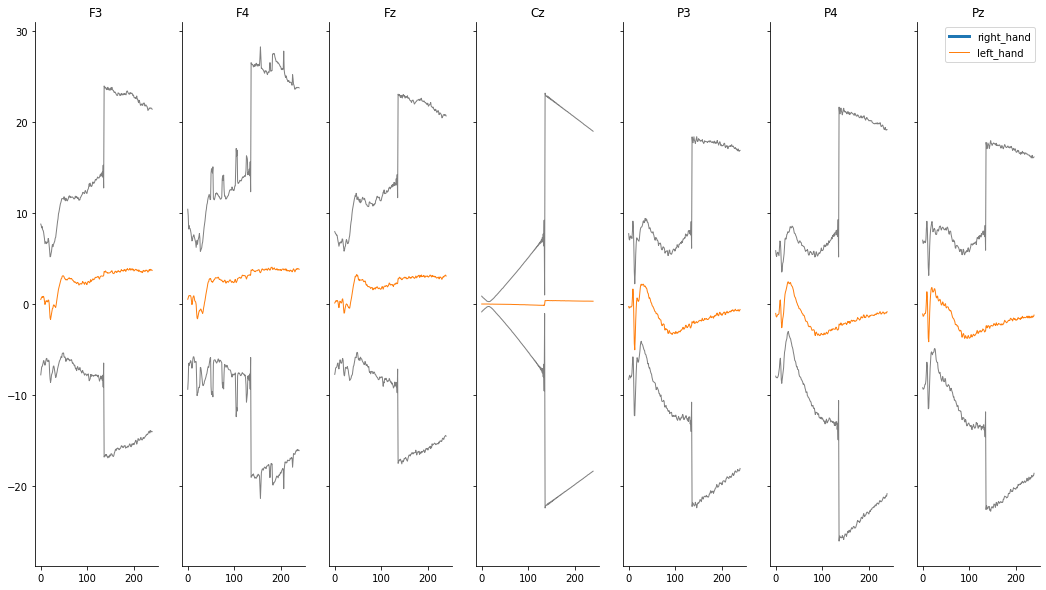

In [11]:
rights = np.where(meta.label.map(labelsToIDs) == 0)[0]
lefts = np.where(meta.label.map(labelsToIDs) == 1)[0]


fix, ax = plt.subplots(1,7, figsize=(18,10), sharey=True)
for i in range(7):
    m = samples[rights,i,:].mean(0).squeeze()
    s = samples[rights,i,:].std(0).squeeze()
    ax[i].plot(m, lw=3, label='right_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=3)
    ax[i].plot(m-s, color='grey', lw=3)
    
    m = samples[lefts,i,:].mean(0).squeeze()
    s = samples[lefts,i,:].std(0).squeeze()
    ax[i].plot(m, lw=1, label='left_hand'if i==6 else None)
    ax[i].plot(m+s, color='grey', lw=1)
    ax[i].plot(m-s, color='grey', lw=1)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.right.set_visible(False)

    
    
    ax[i].set_title(['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz'][i])

plt.legend()